## Importing the necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Flatten, Dropout
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.preprocessing import image

## Getting the path of the training and testing data of the brain tumor dataset

In [2]:
dataset_directory_location = 'brain_dataset'

In [3]:
os.listdir(dataset_directory_location)

['test', 'train']

In [4]:
train_dataset_location = os.path.join(dataset_directory_location, 'train')
test_dataset_location = os.path.join(dataset_directory_location, 'test')

In [5]:
os.listdir(train_dataset_location)

['glioma', 'meningioma', 'notumor', 'pituitary']

In [6]:
os.listdir(test_dataset_location)

['glioma', 'meningioma', 'notumor', 'pituitary']

## Viewing a brain image

In [7]:
brain_img_glicoma = os.path.join(train_dataset_location, 'glioma')

In [8]:
os.listdir(brain_img_glicoma)[:1]

['Tr-gl_0010.jpg']

In [9]:
brain_img_glicoma_read = imread(os.path.join(brain_img_glicoma, 'Tr-gl_0010.jpg'))

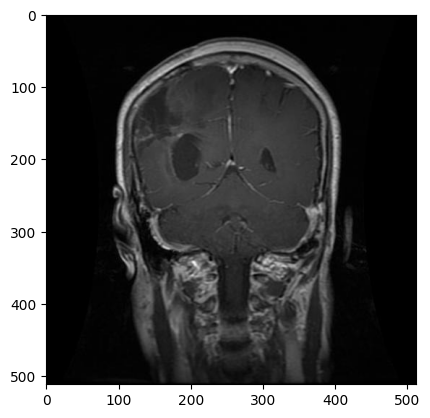

In [10]:
plt.imshow(brain_img_glicoma_read)

In [11]:
brain_img_glicoma_read.shape 

(512, 512, 3)

## Defining the correct shape of the image

In [12]:
correct_image_shape = (224, 224, 3)

## Defining the ImageGenerator and performing Data Augmentation

In [13]:
image_gen = ImageDataGenerator(rotation_range=20, 
                               width_shift_range=0.1, 
                               height_shift_range=0.1, 
                               shear_range=0.1, 
                               zoom_range=0.1, 
                               horizontal_flip=True, 
                               fill_mode='nearest',
                               preprocessing_function=preprocess_input)

In [14]:
train_image_gen = image_gen.flow_from_directory(train_dataset_location, 
                                                target_size=correct_image_shape[:2], 
                                                color_mode='rgb', 
                                                batch_size=16, 
                                                class_mode='categorical')

test_image_gen = image_gen.flow_from_directory(test_dataset_location, 
                                                target_size=correct_image_shape[:2], 
                                                color_mode='rgb', 
                                                batch_size=16, 
                                                class_mode='categorical')

Found 5200 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


## Defining the early stop

In [15]:
early_stop_loss = EarlyStopping(monitor='loss', patience=2)
early_stop_val_loss = EarlyStopping(monitor='val_loss', patience=2)

## Creating and training the model

In [16]:
model = Sequential()

In [17]:
vgg19_model = VGG19(weights='imagenet', include_top=False, input_shape=correct_image_shape)

In [18]:
vgg19_model.trainable = False

In [19]:
model.add(vgg19_model)

model.add(Flatten())

model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

model.add(Dropout(0.3))

model.add(Dense(4, activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 batch_normalization (BatchN  (None, 25088)            100352    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 128)               0

In [21]:
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])

In [22]:
model.fit(train_image_gen, validation_data=test_image_gen, epochs=30, callbacks=[early_stop_loss, early_stop_val_loss])

Epoch 1/30
325/325 [==============================] - 119s 313ms/step - loss: 1.4854 - accuracy: 0.4577 - val_loss: 1.2562 - val_accuracy: 0.5900
Epoch 2/30
325/325 [==============================] - 95s 293ms/step - loss: 0.9946 - accuracy: 0.6329 - val_loss: 1.0540 - val_accuracy: 0.6808
Epoch 3/30
325/325 [==============================] - 95s 292ms/step - loss: 0.8574 - accuracy: 0.6875 - val_loss: 0.9464 - val_accuracy: 0.7033
Epoch 4/30
325/325 [==============================] - 93s 287ms/step - loss: 0.7441 - accuracy: 0.7312 - val_loss: 0.8613 - val_accuracy: 0.7267
Epoch 5/30
325/325 [==============================] - 93s 285ms/step - loss: 0.7051 - accuracy: 0.7448 - val_loss: 0.7309 - val_accuracy: 0.7608
Epoch 6/30
325/325 [==============================] - 95s 292ms/step - loss: 0.6495 - accuracy: 0.7621 - val_loss: 0.6775 - val_accuracy: 0.7867
Epoch 7/30
325/325 [==============================] - 92s 284ms/step - loss: 0.6139 - accuracy: 0.7821 - val_loss: 0.6891 - val_a

In [23]:
history_df = pd.DataFrame(model.history.history)

<Axes: >

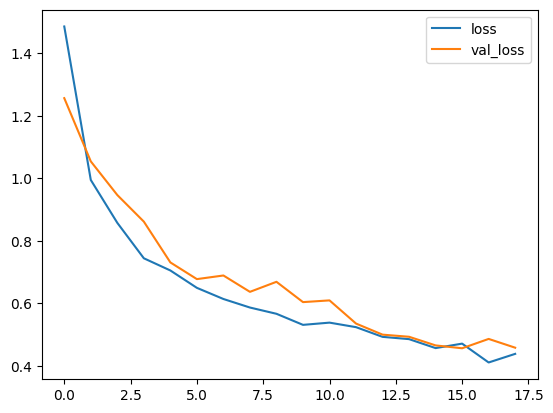

In [24]:
history_df[['loss', 'val_loss']].plot()

<Axes: >

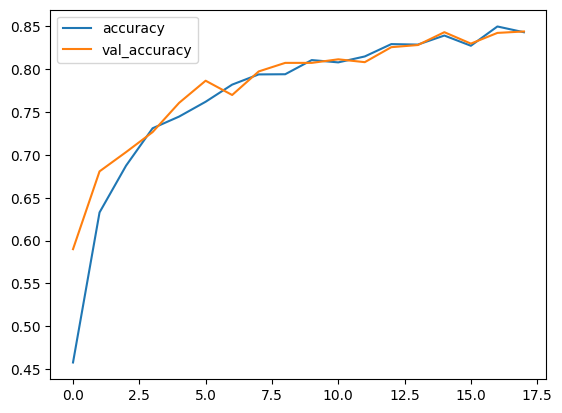

In [25]:
history_df[['accuracy', 'val_accuracy']].plot()

## Evaluating the model

In [26]:
model.evaluate(train_image_gen)[1]

325/325 [==============================] - 76s 232ms/step - loss: 0.2899 - accuracy: 0.8981


0.8980769515037537

In [27]:
model.evaluate(test_image_gen)[1]

75/75 [==============================] - 17s 229ms/step - loss: 0.4464 - accuracy: 0.8392


0.8391666412353516

## Predicting on a sample image

In [28]:
sample_img_load = image.load_img('./brain_dataset/test/pituitary/Te-piTr_0003.jpg', target_size=correct_image_shape)

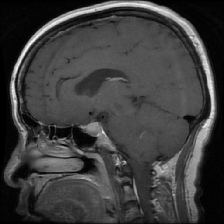

In [29]:
sample_img_load

In [30]:
sample_img_to_arr = image.img_to_array(sample_img_load) 

In [31]:
sample_img_to_arr = preprocess_input(sample_img_to_arr)

In [32]:
sample_img_to_arr_expand_dim = np.expand_dims(sample_img_to_arr, 0) 

In [33]:
prediction = model.predict(sample_img_to_arr_expand_dim)[0]

1/1 [==============================] - 1s 1s/step


In [34]:
pred_result = np.argmax(prediction)

In [35]:
class_names = ['glioma', 'meningioma', 'no tumor', 'pituitary']

In [36]:
pred_final_result = class_names[pred_result]

In [37]:
pred_final_result

'pituitary'

In [38]:
save_model(model, 'vgg19_model')

INFO:tensorflow:Assets written to: vgg19_model\assets


INFO:tensorflow:Assets written to: vgg19_model\assets
